In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Pre-processing

In [75]:
# split dataset into X y train test, based on gene_id
# input: df, split_size
# output: train df, test df
def split(df, split_size=0.2):
    splitter = GroupShuffleSplit(test_size=split_size, n_splits=1, random_state=42)
    split = splitter.split(df, groups=df['gene_id'])
    train_inds, test_inds = next(split)
    train = df.iloc[train_inds]
    test = df.iloc[test_inds]
    
    y_train = train['label']
    X_train = train.drop(['label', 'sevenmers'], axis = 1)
    y_test = test['label']
    X_test = test.drop(['label', 'sevenmers'], axis = 1)
    
    return X_train, y_train, X_test, y_test

# oversample and undersample such that ratio of minority to majority samples becomes 3:4
# input: df, df (X_train, y_train)
# output: df, df (resampled version)
def resample(X_train, y_train):
    # define oversampling strategy so that ratio of minority samples to majority samples is 1:2
    oversample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
    X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
    
    # define undersampling strategy so that the ratio of minority to majority samples becomes 3:4
    under = RandomUnderSampler(sampling_strategy=0.75)
    X_train_under, y_train_under = under.fit_resample(X_train_over, y_train_over)
    return X_train_under, y_train_under


### split

In [88]:
df = pd.read_csv('../data/grouped_data.csv')
X_train, y_train, X_test, y_test = split(df)

### one hot encoding

In [89]:
features_nominal = ['order_1', 'order_2', 'order_3', 'order_4', 'order_5', 'order_6', 'order_7']
X_train = pd.get_dummies(X_train, columns=features_nominal)
X_test = pd.get_dummies(X_test, columns=features_nominal)
print([x for x in X_train.columns])

['gene_id', 'transcript_id', 'transcript_position', 'dwelling_time_1_min', 'dwelling_time_1_max', 'dwelling_time_1_mean', 'dwelling_time_1_median', 'dwelling_time_1_std', 'dwelling_time_1_skew', 'sd_current_1_min', 'sd_current_1_max', 'sd_current_1_mean', 'sd_current_1_median', 'sd_current_1_std', 'sd_current_1_skew', 'mean_current_1_min', 'mean_current_1_max', 'mean_current_1_mean', 'mean_current_1_median', 'mean_current_1_std', 'mean_current_1_skew', 'dwelling_time_2_min', 'dwelling_time_2_max', 'dwelling_time_2_mean', 'dwelling_time_2_median', 'dwelling_time_2_std', 'dwelling_time_2_skew', 'sd_current_2_min', 'sd_current_2_max', 'sd_current_2_mean', 'sd_current_2_median', 'sd_current_2_std', 'sd_current_2_skew', 'mean_current_2_min', 'mean_current_2_max', 'mean_current_2_mean', 'mean_current_2_median', 'mean_current_2_std', 'mean_current_2_skew', 'dwelling_time_3_min', 'dwelling_time_3_max', 'dwelling_time_3_mean', 'dwelling_time_3_median', 'dwelling_time_3_std', 'dwelling_time_3_sk

### resampling

In [90]:
X_train, y_train = resample(X_train, y_train)
X_train = X_train.drop(columns=['gene_id', 'transcript_id'])
X_test = X_test.drop(columns=['gene_id', 'transcript_id'])

# OR
# X_train = pd.read_csv('../data/X_train_final.csv')
# y_train = pd.read_csv('../data/y_train_final.csv')
# X_test = pd.read_csv('../data/X_test_final.csv')
# y_test = pd.read_csv('../data/y_test_final.csv')
# features_nominal = ['order_1', 'order_2', 'order_3', 'order_4', 'order_5', 'order_6', 'order_7']
# X_train[features_nominal] = X_train[features_nominal].astype('category')
# X_test[features_nominal] = X_test[features_nominal].astype('category')

### scaling

In [91]:
scale=StandardScaler()
X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)

# Logistic Regression

In [92]:
logreg = LogisticRegression(max_iter=1000)

### recursive feature elimination (rfe)

like equally bad - kinda useless?

In [94]:
from sklearn.feature_selection import RFE

rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_s, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False  True False  True  True False False False False False False False
 False False False  True False  True False False False  True False  True
 False False False False False False False False False  True False False
 False False False  True  True  True False  True False  True False  True
 False False False  True False False  True  True False False  True  True
  True False False False False]
[44 50 12 45 46 11 23 19 39 13 18 38 49  1 29  1  1 26  2 52 31 51 56 33
 32 25 35  1 43  1 36 20 22  1 30  1 21 53  8 10 24  9 55 40 41  1 17 42
 47  7  6  1  1  1 54  1 28  1  5  1 34 16 15  1  4  3  1  1 57 58  1  1
  1 48 27 37 14]


In [95]:
columns_to_remove = pd.DataFrame(X_train_s).columns.values[np.logical_not(rfe.support_)]
columns_to_remove

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 46, 47, 48, 49, 50, 54, 56, 58, 60, 61, 62, 64, 65,
       68, 69, 73, 74, 75, 76], dtype=int64)

In [96]:
X_train_s_rfe = pd.DataFrame(X_train_s).drop(columns=columns_to_remove)
X_test_s_rfe = pd.DataFrame(X_test_s).drop(columns=columns_to_remove)

In [97]:
logreg.fit(X_train_s_rfe, y_train)
y_pred = logreg.predict(X_test_s_rfe)

### prediction + metrics

In [100]:

logreg.fit(X_train_s, y_train)
y_pred = logreg.predict(X_test_s)

In [101]:
print(f'confusion matrix:\n   {metrics.confusion_matrix(y_test, y_pred)}\n')
# TN FP
# FN TP

print(f'accuracy:   {logreg.score(X_test_s, y_test)}')
print(f'precision: {metrics.precision_score(y_test, y_pred)}')
print(f'recall:    {metrics.recall_score(y_test, y_pred)}')
print(f'roc auc:   {metrics.roc_auc_score(y_test, y_pred)}')
print(f'pr auc:    {metrics.average_precision_score(y_test, y_pred)}\n')

print(f'classification report:\n {metrics.classification_report(y_test, y_pred)}')

confusion matrix:
   [[19786  2862]
 [  267   917]]

accuracy:   0.868705941591138
precision: 0.24265678750992326
recall:    0.7744932432432432
roc auc:   0.8240622344792691
pr auc:    0.1991394663213214

classification report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93     22648
           1       0.24      0.77      0.37      1184

    accuracy                           0.87     23832
   macro avg       0.61      0.82      0.65     23832
weighted avg       0.95      0.87      0.90     23832



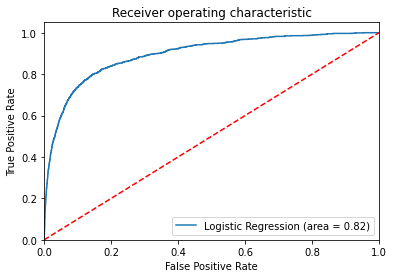

In [102]:
logit_roc_auc = metrics.roc_auc_score(y_test, logreg.predict(X_test_s))
fpr, tpr, thresholds = metrics.roc_curve(y_test, logreg.predict_proba(X_test_s)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()